## Does not make sense

Cannot be finetuned with all 4 losses. The term 1 and term 4 are contradictory.

In [131]:
import numpy as np
import pandas as pd
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import OrderedDict
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [132]:
# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda:5')
else:
    device = torch.device('cpu')
    
print(device)
device = torch.device('cpu')

cpu


In [133]:
# the deep neural network
class MLP(torch.nn.Module):
    def __init__(self, layers, activation="relu", init="xavier"):
        super(MLP, self).__init__()
        
        # parameters
        self.depth = len(layers) - 1
        
        if activation == "relu":
            self.activation = torch.nn.ReLU()
        elif activation == "tanh":
            self.activation = torch.nn.Tanh()
        elif activation == "gelu":
            self.activation = torch.nn.GELU()
        else:
            raise ValueError("Unspecified activation type")
        
        
        layer_list = list()
        for i in range(self.depth - 1): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation))
            
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)
        
        # deploy layers
        self.layers = torch.nn.Sequential(layerDict)

        if init=="xavier":
            self.xavier_init_weights()
        elif init=="kaiming":
            self.kaiming_init_weights()
    
    def xavier_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Xavier Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.xavier_uniform_(m.weight)
                    m.bias.data.fill_(0.0)

    def kaiming_init_weights(self):
        with torch.no_grad():
            print("Initializing Network with Kaiming Initialization..")
            for m in self.layers.modules():
                if hasattr(m, 'weight'):
                    nn.init.kaiming_uniform_(m.weight)
                    m.bias.data.fill_(0.0)
                        
    def forward(self, x):
        out = self.layers(x)
        return out
    
class DataGenerator(torch.utils.data.Dataset):
    def __init__(self, X):
        self.X = X
        
    def __getitem__(self, index):
        return self.X[index]
    
    def __len__(self):
        return len(self.X)

In [134]:
data_df = pd.read_csv("all_data_lake_modeling_in_time_wHeat.csv")
time = data_df['time']
data_df = data_df.drop(columns=['time'])
data_df
display(data_df.head)

<bound method NDFrame.head of        depth  AirTemp_degC  Longwave_Wm-2  Latent_Wm-2  Sensible_Wm-2  \
0          1     10.715021     678.292163  -152.775961      -4.194743   
1          2     10.715021     678.292163  -152.775961      -4.194743   
2          3     10.715021     678.292163  -152.775961      -4.194743   
3          4     10.715021     678.292163  -152.775961      -4.194743   
4          5     10.715021     678.292163  -152.775961      -4.194743   
...      ...           ...            ...          ...            ...   
35370     21     13.595026     718.547070  -230.901096     -40.903561   
35371     22     13.595026     718.547070  -230.901096     -40.903561   
35372     23     13.595026     718.547070  -230.901096     -40.903561   
35373     24     13.595026     718.547070  -230.901096     -40.903561   
35374     25     13.595026     718.547070  -230.901096     -40.903561   

       Shortwave_Wm-2  lightExtinct_m-1  ShearVelocity_mS-1  ShearStress_Nm-2  \
0           

In [135]:
training_frac = 0.60
depth_steps = 25
number_days = len(data_df)//depth_steps
n_obs = int(number_days*training_frac)*depth_steps
print(f"Number of days total: {number_days}")
print(f"Number of training points: {n_obs}")

Number of days total: 1415
Number of training points: 21225


# Normalizing Data

In [136]:
data = data_df.values

train_data = data[:n_obs]
test_data = data[n_obs:]

train_time = time[:n_obs]
test_time = time[n_obs:]

#performing normalization on all the columns
scaler = StandardScaler()
scaler.fit(train_data)
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

In [137]:
m0_output_column_ix = [data_df.columns.get_loc(column) for column in ['temp_heat00']]

# Loading Models

In [138]:
m0_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1','Area_m2', 
                 'day_of_year', 'time_of_day', 'input_temp']
m0_output_columns = ['temp_heat00']

m0_input_column_ix = [data_df.columns.get_loc(column) for column in m0_input_columns]
m0_output_column_ix = [data_df.columns.get_loc(column) for column in m0_output_columns]

m0_PATH =  f"./saved_models/heating_model_time.pth"
m0_layers = [len(m0_input_columns), 32, 32, len(m0_output_columns)]

heating_model = MLP(m0_layers, activation="gelu")
m0_checkpoint = torch.load(m0_PATH, map_location=torch.device('cpu'))
heating_model.load_state_dict(m0_checkpoint)
heating_model = heating_model.to(device)

Initializing Network with Xavier Initialization..


## Heat Diffusion Model

In [139]:
m1_input_columns = ['depth', 'AirTemp_degC', 'Longwave_Wm-2', 'Latent_Wm-2', 'Sensible_Wm-2', 'Shortwave_Wm-2',
                'lightExtinct_m-1', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'Area_m2', 
                 'buoyancy', 'day_of_year', 'time_of_day', 'diffusivity', 'temp_heat00']
m1_output_columns = ['temp_diff01']

m1_input_column_ix = [data_df.columns.get_loc(column) for column in m1_input_columns]
m1_output_column_ix = [data_df.columns.get_loc(column) for column in m1_output_columns]

m1_PATH = f"./saved_models/heat_diffusion_model_time.pth"
m1_layers = [len(m1_input_columns), 32, 32, len(m1_output_columns)]

heat_diff_model = MLP(m1_layers, activation="gelu")
m1_checkpoint = torch.load(m1_PATH, map_location=torch.device('cpu'))
heat_diff_model.load_state_dict(m1_checkpoint)
heat_diff_model = heat_diff_model.to(device)

Initializing Network with Xavier Initialization..


## Mixing Model

In [140]:
m2_input_columns = ['depth', 'ShearVelocity_mS-1', 'ShearStress_Nm-2', 'day_of_year', 'time_of_day', 'temp_diff01']
m2_output_columns = ['temp_mix02']

m2_input_column_ix = [data_df.columns.get_loc(column) for column in m2_input_columns]
m2_output_column_ix = [data_df.columns.get_loc(column) for column in m2_output_columns]

m2_PATH = f"./saved_models/mixing_model_time.pth"
m2_layers = [len(m2_input_columns), 32, 32, len(m2_output_columns)]

mixing_model = MLP(m2_layers, activation="gelu")
m2_checkpoint = torch.load(m2_PATH, map_location=torch.device('cpu'))
mixing_model.load_state_dict(m2_checkpoint)
mixing_model = mixing_model.to(device)

Initializing Network with Xavier Initialization..


# Convection Model

In [141]:
m3_input_columns = ['depth', 'day_of_year', 'time_of_day', 'temp_mix02']
m3_output_columns = ['temp_conv03']

m3_input_column_ix = [data_df.columns.get_loc(column) for column in m3_input_columns]
m3_output_column_ix = [data_df.columns.get_loc(column) for column in m3_output_columns]

m3_PATH = f"./saved_models/convection_model_time.pth"
m3_layers = [len(m3_input_columns), 32, 32, len(m3_output_columns)]

convection_model = MLP(m3_layers, activation="gelu")
m3_checkpoint = torch.load(m3_PATH, map_location=torch.device('cpu'))
convection_model.load_state_dict(m3_checkpoint)
convection_model = convection_model.to(device)

Initializing Network with Xavier Initialization..


# Ice Model

In [142]:
m4_input_columns = ['depth', 'day_of_year', 'time_of_day', 'temp_conv03']
m4_output_columns = ['temp_total04']

m4_input_column_ix = [data_df.columns.get_loc(column) for column in m4_input_columns]
m4_output_column_ix = [data_df.columns.get_loc(column) for column in m4_output_columns]

m4_PATH = f"./saved_models/ice_model_time.pth"
m4_layers = [len(m4_input_columns), 32, 32, len(m4_output_columns)]

ice_model = MLP(m4_layers, activation="gelu")
m4_checkpoint = torch.load(m4_PATH, map_location=torch.device('cpu'))
ice_model.load_state_dict(m4_checkpoint)
ice_model = ice_model.to(device)

Initializing Network with Xavier Initialization..


In [143]:
obs_temp_columns = ['obs_temp']

obs_temp_columns_ix = [data_df.columns.get_loc(column) for column in obs_temp_columns]

In [144]:
# depth_steps = 24
# train_data = np.reshape(train_data, (train_data.shape[0]//depth_steps, depth_steps, train_data.shape[1]))
# test_data = np.reshape(test_data, (test_data.shape[0]//depth_steps, depth_steps, test_data.shape[1]))

In [145]:
#keeping track of the mean and standard deviations
train_mean = scaler.mean_
train_std = scaler.scale_

In [146]:
# Create data set
batch_size = 1000

assert batch_size % 25 ==0, "Batchsize has to be multiple of 25" 

train_dataset = DataGenerator(train_data)
test_dataset = DataGenerator(test_data)
# train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
# test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, 
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                          shuffle=False)

In [147]:
print(train_data.shape)
print(test_data.shape)

(21225, 22)
(14150, 22)


In [148]:
def rmse(true, pred):
    return (((true-pred)**2).mean()**0.5).detach().cpu().numpy()

def l2_error(true, pred):
    return np.linalg.norm(pred.detach().cpu().numpy() - true.detach().cpu().numpy()) / np.linalg.norm(true.detach().cpu().numpy()) 

In [149]:
#keeping track of the mean and standard deviations

input_mean, input_std = train_mean[m1_input_column_ix], train_std[m1_input_column_ix]
output_mean, output_std = train_mean[m1_output_column_ix], train_std[m1_output_column_ix]

mean_diff = torch.tensor(input_mean[m1_input_column_ix[13]]).to(device)
std_diff = torch.tensor(input_std[m1_input_column_ix[13]]).to(device)

mean_temp = torch.tensor(input_mean[m1_input_column_ix[14]]).to(device)
std_temp = torch.tensor(input_std[m1_input_column_ix[14]]).to(device)

mean_out = torch.tensor(output_mean).to(device)
std_out = torch.tensor(output_std).to(device)
    
def implicit_diffusion(diff, temp, dt=3600, dx=1, depth_steps=25):
    # de-normalise data
    diff = diff * std_diff + mean_diff
    diff = diff.view(-1, depth_steps)
    
    # INPUT DATA FROM PREVIOUS MODULE
    t = temp * std_temp + mean_temp # temperature profile from previous module output
    t = t.view(-1, depth_steps)
    
    # IMPLEMENTATION OF CRANK-NICHOLSON SCHEME
#     len_t = t.shape[1]
    y = torch.zeros((t.shape[0], depth_steps, depth_steps), dtype=torch.float64).to(device)

    alpha = (dt/dx**2) * diff

    az = - alpha # subdiagonal
    bz = 2 * (1 + alpha) # diagonal
    cz = - alpha # superdiagonal
    
    bz[:, 0] = 1
    az[:, depth_steps-2] = 0
    bz[:, depth_steps-1] = 1
    cz[:, 0] = 0
    
    az = az[:,1:]
    cz = cz[:,:-1]

    y = torch.diag_embed(bz, offset=0)+torch.diag_embed(az,offset=-1)+torch.diag_embed(cz,offset=1) #slightly efficient way of computing the diagonal matrices
    y[:, depth_steps-1, depth_steps-1] = 1
    
    mn = torch.zeros_like(t)  
    mn[:, 0] = t[:, 0]
    mn[:,depth_steps-1] = t[:, depth_steps-1]
    
    mn[:, 1:depth_steps-1] = alpha[:, 1:depth_steps-1]*t[:, :depth_steps-2] + 2 * (1 - alpha[:,1:depth_steps-1])*t[:,1:depth_steps-1] + alpha[:,1:depth_steps-1]*t[:,1:depth_steps-1] #is be same as the loop
    
    # DERIVED TEMPERATURE OUTPUT FOR NEXT MODULE
    proj = torch.linalg.solve(y, mn)

    mean, std, var = torch.mean(proj), torch.std(proj), torch.var(proj)
    proj = (proj-mean_out)/std_out

    proj = proj.to(torch.float32)
    proj = proj.view(-1, 1)
    return proj

In [150]:
def compute_metrics(model, loader, input_columns, output_columns, train_mean, train_std):
    model.eval()
    y_ = []
    pred_ = []
    mean = torch.tensor(train_mean[output_columns]).to(device)
    std = torch.tensor(train_std[output_columns]).to(device)
    
    for x in iter(loader):
        inputs, target = x[:, input_columns].to(device).float(), x[:, output_columns].to(device).float()
        pred = model(inputs)
        target = target * std + mean
        pred = pred * std + mean
        y_.append(target)
        pred_.append(pred)
    y_ = torch.cat(y_, dim=0) 
    pred_ = torch.cat(pred_, dim=0)
    
    if y_.shape[1]==2:
        rmse_temp = rmse(y_[:,1], pred_[:,1])
        l2_error_temp = l2_error(y_[:,1], pred_[:,1])
    else:
        rmse_temp = rmse(y_[:,0], pred_[:,0])
        l2_error_temp = l2_error(y_[:,0], pred_[:,0])
        
    return rmse_temp, l2_error_temp

In [151]:
print(m1_input_column_ix)
print(m1_input_column_ix[:-1])
print(m1_input_column_ix[:-2])
print(m1_input_column_ix[14])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 16, 17, 13, 14]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 16, 17, 13]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 16, 17]
14


In [152]:
def get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, loader, plot = True):    
    heating_model.eval()
    heat_diff_model.eval()
    mixing_model.eval()
    convection_model.eval()
    ice_model.eval()

    mean = torch.tensor(train_mean[m4_output_column_ix]).float().to(device)
    std = torch.tensor(train_std[m4_output_column_ix]).float().to(device)

    m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
    m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

#     depthwise_y_pred = []
#     depthwise_y_true = []
    y_ = []
    y_obs_ = []
    pred_ = []
        
    rmse_models = np.zeros((len(loader), 5))
    for ix, x in enumerate(iter(loader)):
        x = x.to(device).float()
        
        m0_input = x[:, m0_input_column_ix]
            
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
            
        if plot:
            m0_y_true = x[:, m0_output_column_ix[0]] * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
            m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 0] = rmse(m0_y_true.squeeze(), m0_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m0", rmse(m0_y_true.flatten(), m0_y_pred.flatten()))

        #model 2
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m0_pred], dim=-1)
        #m1_input = x[:, m1_input_column_ix]
            
        #model 1
        # m1_pred = heat_diff_model(m1_input) #predicts diff and temp
        
        temp_input = m0_y_pred = m0_pred * torch.tensor(train_std[m0_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m0_output_column_ix[0]]).to(device)
       # print(temp_input)
        
        proj = heat_diff_model(m1_input)
        
        pred = implicit_diffusion(proj, m0_pred)        
        m1_pred = pred.to(dtype=torch.float32)
        
        #print(m1_pred)
        
        if plot:
            m1_y_true = x[:, m1_output_column_ix[0]] * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
            m1_y_pred = m1_pred * torch.tensor(train_std[m1_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m1_output_column_ix[0]]).to(device)
#             print(m1_y_true.shape, m1_y_pred.shape)
#             print("True",m1_y_true)
#             print("Pred",m1_y_pred)
            rmse_models[ix, 1] = rmse(m1_y_true.squeeze(), m1_y_pred.squeeze())
#             print(x[:, m1_output_column_ix[1]])
#             print(m1_pred_temp)
#             print(criterion(m1_pred_temp, x[:, m1_output_column_ix[1]]))
            print("RMSE of after m1", rmse(m1_y_true.flatten(), m1_y_pred.flatten()))

        #model 2
        m2_input = torch.cat([x[:, m2_input_column_ix[:-1]], m1_pred], dim=-1)
        m2_pred = mixing_model(m2_input)
            
        if plot:
            m2_y_true = x[:, m2_output_column_ix] * torch.tensor(train_std[m2_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m2_output_column_ix[0]]).to(device)
            m2_y_pred = m2_pred * torch.tensor(train_std[m2_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m2_output_column_ix[0]]).to(device)
            rmse_models[ix, 2] = rmse(m2_y_true.squeeze(), m2_y_pred.squeeze())
            print("RMSE of after m2", rmse(m2_y_true.flatten(), m2_y_pred.flatten()))

        #model 3
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m2_pred], dim=-1)
        m3_pred = convection_model(m3_input)
            
        if plot:
            m3_y_true = x[:, m3_output_column_ix] * torch.tensor(train_std[m3_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m3_output_column_ix[0]]).to(device)
            m3_y_pred = m3_pred * torch.tensor(train_std[m3_output_column_ix[0]]).to(device) + torch.tensor(train_mean[m3_output_column_ix[0]]).to(device)
            rmse_models[ix, 3] = rmse(m3_y_true.squeeze(), m3_y_pred.squeeze())
            print("RMSE of after m3", rmse(m3_y_true.flatten(), m3_y_pred.flatten()))

        #model 4
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m3_pred], dim=-1)
        m4_pred = ice_model(m4_input)
            
        if plot:
            m4_y_true = x[:, m4_output_column_ix] * std + mean
            m4_y_pred = m4_pred * std + mean
            rmse_models[ix, 4] = rmse(m4_y_true.squeeze(), m4_y_pred.squeeze())
            print("RMSE of after m4", rmse(m4_y_true.flatten(), m4_y_pred.flatten()))

        y_true = x[:, m4_output_column_ix] * std + mean
        y_obs = x[:, obs_temp_columns_ix] * train_std[obs_temp_columns_ix[0]] + train_mean[obs_temp_columns_ix[0]]
        pred = m4_pred * std + mean
        
        y_.append(y_true)
        y_obs_.append(y_obs)
        pred_.append(pred)

    y_ = torch.cat(y_, dim=0)
    y_obs_ = torch.cat(y_obs_, dim=0)
    pred_ = torch.cat(pred_, dim=0) 
    
    #if plot:   
     #        rmse_models = rmse_models.mean(axis=0)
     #        plt.figure(figsize=(12,8))
     #        plt.plot(rmse_models[:, 0], label="RMSE after Heating Model")
     #        plt.plot(rmse_models[:, 1], label="RMSE after Heat-Diffusion Model")
     #        plt.plot(rmse_models[:, 2], label="RMSE after Mixing Model")
     #        plt.plot(rmse_models[:, 3], label="RMSE after Convection Model")
     #        plt.plot(rmse_models[:, 4], label="RMSE after Ice Model")
     #        plt.legend(loc="upper left", fontsize=12)
     #        plt.xlabel("Depth", fontsize=12)
     #        plt.ylabel("RMSE", fontsize=12)
     #        plt.grid("on", alpha=0.5)
     #        plt.show()
    
    return pred_, y_, y_obs_, rmse_models


In [153]:
def plot_output(y_pred, y_true, depth_steps, time_label, figsize=(20,10)):
    time_label = np.array([time[:10] for time in time_label])
    time_label = time_label[::depth_steps]
    
    y_pred = y_pred.flatten().detach().cpu().numpy()
    y_true = y_true.flatten().detach().cpu().numpy()
    
    y_true = np.reshape(y_true, (y_true.shape[0]//depth_steps, depth_steps))
    y_pred = np.reshape(y_pred, (y_pred.shape[0]//depth_steps, depth_steps))
    
    N_pts = 6 # number of points to display on the x-label
    
    fig, ax = plt.subplots(3, 1, figsize=figsize)
    sns.heatmap(y_true.T, ax=ax[0], cmap='seismic', vmin=0., vmax=35.)
    ax[0].set_ylabel("Depth", fontsize=15)
    ax[0].set_xlabel("Time", fontsize=15)
    
    xticks_ix = np.array(ax[0].get_xticks()).astype(int)
    time_label = time_label[xticks_ix]
    nelement = len(time_label)//N_pts
    time_label = time_label[::nelement]
    ax[0].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[0].set_xticklabels(time_label, rotation=0)   
#     ax[0].xaxis.set_major_locator(plt.MultipleLocator(100))
    ax[0].collections[0].colorbar.set_label("Actual Temperature")
    
    sns.heatmap(y_pred.T, ax=ax[1], cmap='seismic', vmin=0., vmax=35.)
    ax[1].set_ylabel("Depth", fontsize=15)
    ax[1].set_xlabel("Time", fontsize=15)
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[1].set_xticklabels(time_label, rotation=0)
    ax[1].collections[0].colorbar.set_label("Predicted Temperature")
    
    sns.heatmap(np.abs(y_pred.T-y_true.T), ax=ax[2], cmap='viridis')
    ax[2].set_ylabel("Depth", fontsize=15)
    ax[2].set_xlabel("Time", fontsize=15)
    ax[2].xaxis.set_major_locator(plt.MaxNLocator(N_pts))
    ax[2].set_xticklabels(time_label, rotation=0)
    
    ax[2].collections[0].colorbar.set_label("Absolute Error")
    plt.show()

# Rollout Results

## Training Results

In [154]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 0.040790718
RMSE of after m1 0.0406216
RMSE of after m2 0.073581815
RMSE of after m3 0.07378493
RMSE of after m4 0.07393468
RMSE of after m0 0.02694151
RMSE of after m1 0.029010247
RMSE of after m2 0.065640666
RMSE of after m3 0.06550051
RMSE of after m4 0.0655303
RMSE of after m0 0.030935071
RMSE of after m1 0.030558553
RMSE of after m2 0.045812797
RMSE of after m3 0.046128113
RMSE of after m4 0.04619307
RMSE of after m0 0.027811687
RMSE of after m1 0.027457394
RMSE of after m2 0.03511642
RMSE of after m3 0.035224736
RMSE of after m4 0.03531401
RMSE of after m0 0.018092897
RMSE of after m1 0.018267853
RMSE of after m2 0.018077847
RMSE of after m3 0.016574642
RMSE of after m4 0.017164158
RMSE of after m0 0.026274059
RMSE of after m1 0.025613833
RMSE of after m2 0.02625916
RMSE of after m3 0.025798632
RMSE of after m4 0.025621321
RMSE of after m0 0.032673795
RMSE of after m1 0.031240685
RMSE of after m2 0.03184577
RMSE of after m3 0.03158731
RMSE of after m4 0.03151659


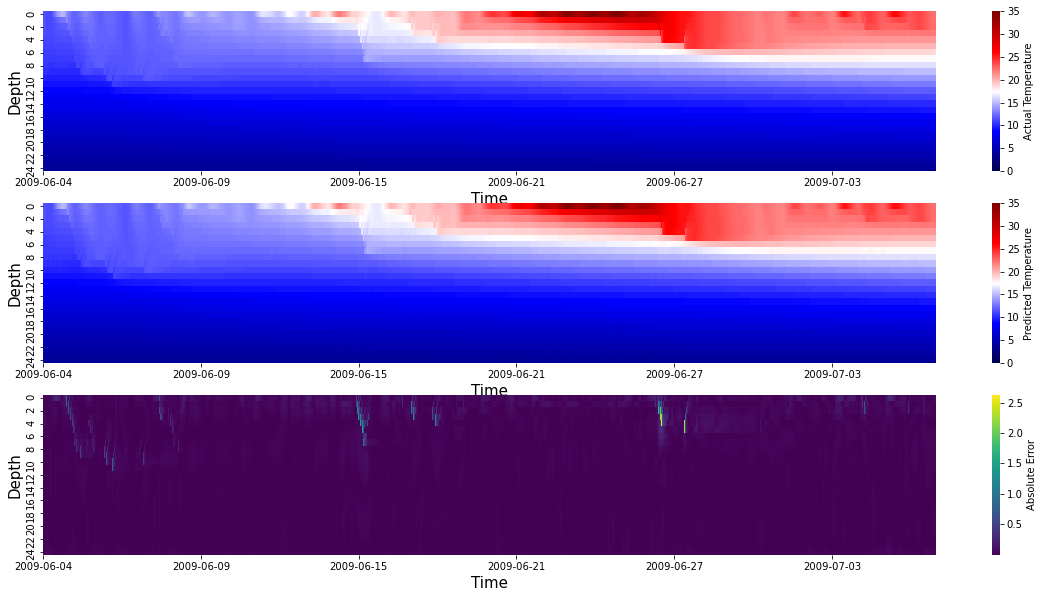

In [155]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

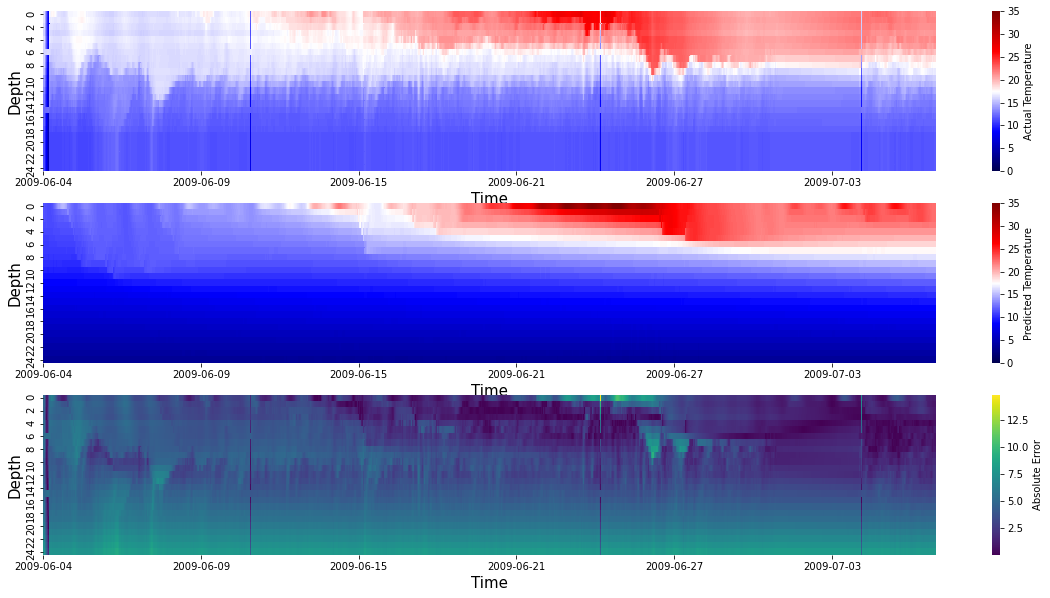

In [156]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

## Test Results

In [157]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model,heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.06562188
RMSE of after m1 0.06522825
RMSE of after m2 0.06941229
RMSE of after m3 0.06995961
RMSE of after m4 0.06895611
RMSE of after m0 0.10146639
RMSE of after m1 0.10189972
RMSE of after m2 0.09875123
RMSE of after m3 0.09711357
RMSE of after m4 0.093208164
RMSE of after m0 0.17078224
RMSE of after m1 0.1725752
RMSE of after m2 0.17143776
RMSE of after m3 0.1653996
RMSE of after m4 0.16397317
RMSE of after m0 0.26712635
RMSE of after m1 0.27102828
RMSE of after m2 0.32311815
RMSE of after m3 0.31740636
RMSE of after m4 0.31133285
RMSE of after m0 0.44920224
RMSE of after m1 0.45351428
RMSE of after m2 0.46546906
RMSE of after m3 0.4500137
RMSE of after m4 0.44361234
RMSE of after m0 0.681121
RMSE of after m1 0.68547267
RMSE of after m2 0.7058388
RMSE of after m3 0.69344866
RMSE of after m4 0.7118805
RMSE of after m0 0.7807158
RMSE of after m1 0.78068304
RMSE of after m2 0.8167686
RMSE of after m3 0.81059533
RMSE of after m4 0.8382801
RMSE of after m0 0.7658944
RM

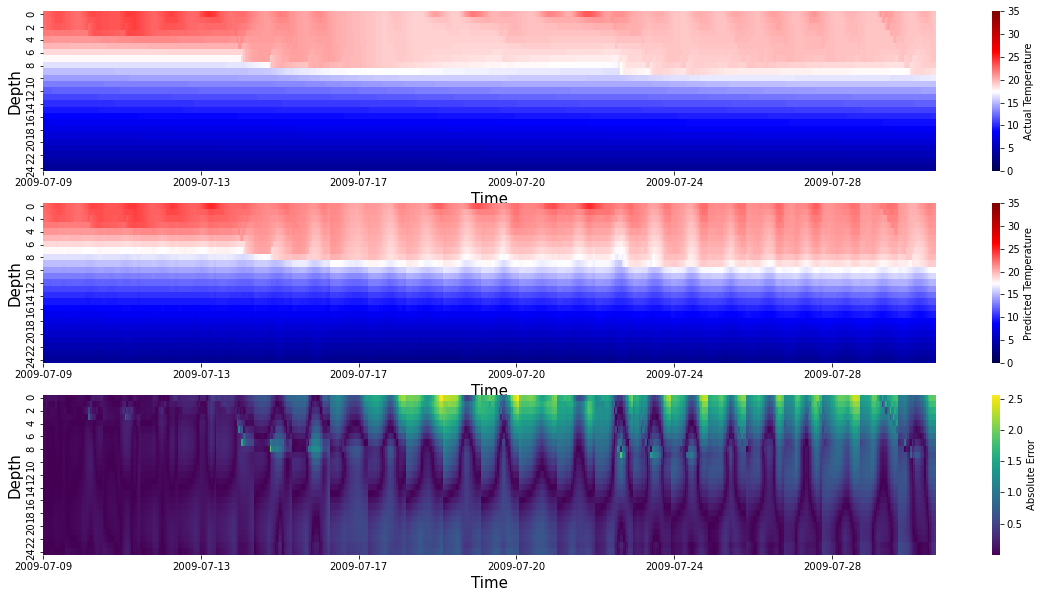

In [158]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

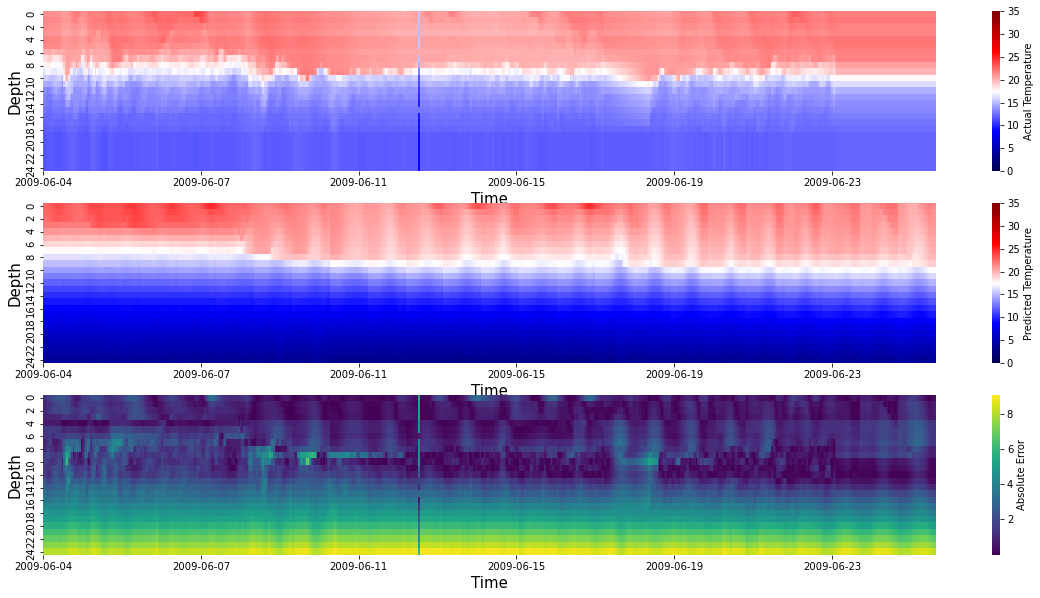

In [159]:
plot_output(test_y_pred, test_y_obs, depth_steps, train_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [160]:
train_rmse, train_l2_err = compute_metrics( heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 13.247666794917814, Train L2 Error: 1.0349137087523108
Test RMSE: 17.151366121065934, Train L2 Error: 1.1812271549958817


## Mixing Model

In [161]:
train_rmse, train_l2_err = compute_metrics(mixing_model, train_loader, m2_input_column_ix, m2_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(mixing_model, test_loader, m2_input_column_ix, m2_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.06464672824655986, Train L2 Error: 0.005050188168577174
Test RMSE: 0.17823362266681597, Train L2 Error: 0.012274653288983025


## Convection Model

In [162]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.007789867537878315, Train L2 Error: 0.000608548609448087
Test RMSE: 0.0453234012849974, Train L2 Error: 0.0031213991515471797


## Ice Model

In [163]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.002282330588951952, Train L2 Error: 0.000178296883670224
Test RMSE: 0.12300266909677181, Train L2 Error: 0.00847113005801246


# Finetuning

In [164]:
lr = 1e-5
# decay_rate = 0.1
# decay_steps = 500

params = list(heating_model.parameters()) + list(heat_diff_model.parameters()) + list(mixing_model.parameters()) + list(convection_model.parameters()) + list(ice_model.parameters())

optimizer = torch.optim.Adam(params, lr=lr, 
                             betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=decay_steps, gamma=decay_rate)

criterion = torch.nn.MSELoss()

# Freeze model weights

In [165]:
def freeze_model(model):
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_model(model):
    for param in model.parameters():
        param.requires_grad = True

In [166]:
freeze_model(heating_model)
freeze_model(mixing_model)
freeze_model(convection_model)
freeze_model(ice_model)

# Finetuning on Observed Temperature

In [167]:
heating_model.train()
heat_diff_model.train()
mixing_model.train()
convection_model.train()
ice_model.train()

n_epochs = 500

# mean and standard dev of "temp_total04" of model 4 output
mean_out4 = torch.tensor(train_mean[m4_output_column_ix[0]]).float().to(device)
std_out4 = torch.tensor(train_std[m4_output_column_ix[0]]).float().to(device)

mean_obs = torch.tensor(train_mean[obs_temp_columns_ix[0]]).float().to(device)
std_obs = torch.tensor(train_std[obs_temp_columns_ix[0]]).float().to(device)

# mean and standard dev of "input_temp" of model 1 input
m1_mean = torch.tensor(train_mean[m1_input_column_ix[-1]]).float().to(device)
m1_std = torch.tensor(train_std[m1_input_column_ix[-1]]).float().to(device)

train_loss = []
LOSS_m0 = []
LOSS_m1 = []
LOSS_m2 = []
LOSS_m3 = []
LOSS_m4 = []

for it in tqdm(range(n_epochs)):
    loss_epoch = 0
    loss_epoch_m0 = 0
    loss_epoch_m1 = 0
    loss_epoch_m2 = 0
    loss_epoch_m3 = 0
    loss_epoch_m4 = 0
    for ix, x in enumerate(iter(train_loader)):
        x = x.to(device).float()
        optimizer.zero_grad()
        
      #  m1_input = x[:, m1_input_column_ix]
        m0_input = x[:, m0_input_column_ix]
        
        #model 0
        m0_pred = heating_model(m0_input) #predicts diff and temp
        loss_m0 = criterion(m0_pred, x[:, m0_output_column_ix])

        #model 1
        m1_input = torch.cat([x[:, m1_input_column_ix[:-1]], m0_pred], dim=-1)
        # m1_pred = heat_diff_model(m1_input)
        
        proj = heat_diff_model(m1_input)
        pred = implicit_diffusion(proj, m0_pred)        
        m1_pred = pred.to(dtype=torch.float32)
                
        loss_m1 = criterion(m1_pred, x[:, m1_output_column_ix])
        
        #m1_pred = heat_diff_model(m1_input) #predicts diff and temp
        #m1_pred_temp = m1_pred[:,1:2]
            
        #loss_m1 = criterion(m1_pred_temp, x[:, m1_output_column_ix[1]].unsqueeze(1))

        #model 2
        m2_input = torch.cat([x[:, m2_input_column_ix[:-1]], m1_pred], dim=-1)
        m2_pred = mixing_model(m2_input)
            
        loss_m2 = criterion(m2_pred, x[:, m2_output_column_ix])

        #model 3
        m3_input = torch.cat([x[:, m3_input_column_ix[:-1]], m2_pred], dim=-1)
        m3_pred = convection_model(m3_input)

        loss_m3 = criterion(m3_pred, x[:, m3_output_column_ix])

        #model 4
        m4_input = torch.cat([x[:, m4_input_column_ix[:-1]], m3_pred], dim=-1)
        m4_pred = ice_model(m4_input)
        
        obs_temp_true = x[:, obs_temp_columns_ix] * std_obs + mean_obs
        obs_temp_true_norm = (obs_temp_true - mean_out4)/std_out4
        
        loss_m4 = criterion(m4_pred, obs_temp_true_norm)

        #loss = (loss_m0 + loss_m1 + loss_m2 + loss_m3 + loss_m4)
        
        loss = loss_m4
        
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss.item()
        loss_epoch_m0 += loss_m0.item()
        loss_epoch_m1 += loss_m1.item()
        loss_epoch_m2 += loss_m2.item()
        loss_epoch_m3 += loss_m3.item()
        loss_epoch_m4 += loss_m4.item()
    
    loss_epoch = loss_epoch/len(train_loader)
    loss_epoch_m0 = loss_epoch_m0/len(train_loader)
    loss_epoch_m1 = loss_epoch_m1/len(train_loader)
    loss_epoch_m2 = loss_epoch_m2/len(train_loader)
    loss_epoch_m3 = loss_epoch_m3/len(train_loader)
    loss_epoch_m4 = loss_epoch_m4/len(train_loader)
    
    train_loss.append(loss_epoch)
    LOSS_m0.append(loss_epoch_m0)
    LOSS_m1.append(loss_epoch_m1)
    LOSS_m2.append(loss_epoch_m2)
    LOSS_m3.append(loss_epoch_m3)
    LOSS_m4.append(loss_epoch_m4)
    if it % 50 == 0:
        print(f"Epoch : {it}, Train_loss: {train_loss[-1]}, Loss m0: {LOSS_m0[-1]}, Loss m1: {LOSS_m1[-1]}, Loss m2: {LOSS_m2[-1]}, Loss m3: {LOSS_m3[-1]}, Loss m4: {LOSS_m4[-1]}")
    
    #plot the loss_m1, m2


  0%|          | 1/500 [00:00<02:35,  3.21it/s]

Epoch : 0, Train_loss: 0.5812890516086058, Loss m0: 2.3768347814852447e-05, Loss m1: 2.4824299213254232e-05, Loss m2: 0.0001283646941952942, Loss m3: 0.00012869384537142733, Loss m4: 0.5812890516086058


 10%|█         | 51/500 [00:23<05:21,  1.40it/s]

Epoch : 50, Train_loss: 0.5799996744502675, Loss m0: 2.3768347814852447e-05, Loss m1: 3.085424288490851e-05, Loss m2: 0.00013370971902821276, Loss m3: 0.00013319608784844274, Loss m4: 0.5799996744502675


 20%|██        | 101/500 [00:46<02:59,  2.23it/s]

Epoch : 100, Train_loss: 0.5788068730722774, Loss m0: 2.3768347814852447e-05, Loss m1: 5.0952521633007564e-05, Loss m2: 0.00015186057035779496, Loss m3: 0.0001494187736997529, Loss m4: 0.5788068730722774


 30%|███       | 151/500 [01:09<02:40,  2.17it/s]

Epoch : 150, Train_loss: 0.5775999453934756, Loss m0: 2.3768347814852447e-05, Loss m1: 8.533351071739823e-05, Loss m2: 0.00018309959688684268, Loss m3: 0.00017757148188221353, Loss m4: 0.5775999453934756


 40%|████      | 201/500 [01:31<01:26,  3.45it/s]

Epoch : 200, Train_loss: 0.5763405155051838, Loss m0: 2.3768347814852447e-05, Loss m1: 0.00013601773786252704, Loss m2: 0.00022928814889217557, Loss m3: 0.0002192996421812991, Loss m4: 0.5763405155051838


 50%|█████     | 251/500 [01:45<01:09,  3.60it/s]

Epoch : 250, Train_loss: 0.5750153227285906, Loss m0: 2.3768347814852447e-05, Loss m1: 0.000205033309281465, Loss m2: 0.0002923310338784094, Loss m3: 0.00027631625793715517, Loss m4: 0.5750153227285906


 60%|██████    | 301/500 [02:01<00:55,  3.58it/s]

Epoch : 300, Train_loss: 0.5736090148037131, Loss m0: 2.3768347814852447e-05, Loss m1: 0.000295058304221708, Loss m2: 0.0003747697879920121, Loss m3: 0.00035093317803164774, Loss m4: 0.5736090148037131


 70%|███████   | 351/500 [02:16<00:40,  3.65it/s]

Epoch : 350, Train_loss: 0.5721079801971262, Loss m0: 2.3768347814852447e-05, Loss m1: 0.0004091923394960097, Loss m2: 0.00047956915461161935, Loss m3: 0.00044585657451534644, Loss m4: 0.5721079801971262


 80%|████████  | 401/500 [02:30<00:27,  3.59it/s]

Epoch : 400, Train_loss: 0.5704984895207665, Loss m0: 2.3768347814852447e-05, Loss m1: 0.0005509626974923198, Loss m2: 0.0006101149470354853, Loss m3: 0.0005641788805157623, Loss m4: 0.5704984895207665


 90%|█████████ | 451/500 [02:44<00:14,  3.41it/s]

Epoch : 450, Train_loss: 0.56876010380008, Loss m0: 2.3768347814852447e-05, Loss m1: 0.0007250319891185923, Loss m2: 0.0007708793511317873, Loss m3: 0.0007099932594097812, Loss m4: 0.56876010380008


100%|██████████| 500/500 [02:57<00:00,  2.81it/s]


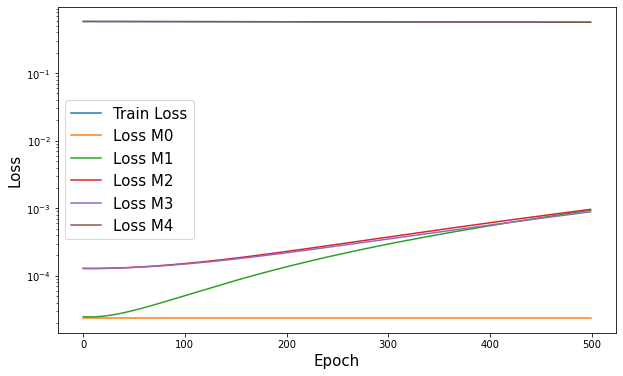

In [168]:
plt.figure(figsize=(10,6))
plt.plot(train_loss, label = "Train Loss")
plt.plot(LOSS_m0, label = "Loss M0")
plt.plot(LOSS_m1, label = "Loss M1")
plt.plot(LOSS_m2, label = "Loss M2")
plt.plot(LOSS_m3, label = "Loss M3")
plt.plot(LOSS_m4, label = "Loss M4")
plt.ylabel("Loss", fontsize=15)
plt.xlabel("Epoch", fontsize=15)
plt.yscale("log")
plt.legend(fontsize=15)
plt.show()

# Rollout Evaluation After FineTuning

In [169]:
train_y_pred, train_y_true, train_y_obs, train_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, train_loader, plot = True)

train_rmse = rmse(train_y_pred.flatten(), train_y_true.flatten())
train_rmse_obs = rmse(train_y_pred.flatten(), train_y_obs.flatten())
train_l2 = l2_error(train_y_pred.flatten(), train_y_true.flatten())

print(f"Train RMSE Simulated: {train_rmse}")
print(f"Train RMSE Observed Temp: {train_rmse_obs}")
print(f"Train L2 Error: {train_l2}")
print(f"The RMSEs after each modelling stage: {train_rmse_models.mean(axis=0)}")

RMSE of after m0 0.040790718
RMSE of after m1 0.19825642
RMSE of after m2 0.204996
RMSE of after m3 0.19871485
RMSE of after m4 0.1940389
RMSE of after m0 0.02694151
RMSE of after m1 0.18954995
RMSE of after m2 0.19177045
RMSE of after m3 0.18555522
RMSE of after m4 0.18079455
RMSE of after m0 0.030935071
RMSE of after m1 0.19479825
RMSE of after m2 0.19268551
RMSE of after m3 0.18649866
RMSE of after m4 0.18020546
RMSE of after m0 0.027811687
RMSE of after m1 0.19659688
RMSE of after m2 0.19771188
RMSE of after m3 0.19031262
RMSE of after m4 0.1845839
RMSE of after m0 0.018092897
RMSE of after m1 0.19367357
RMSE of after m2 0.19250253
RMSE of after m3 0.18481658
RMSE of after m4 0.17859279
RMSE of after m0 0.026274059
RMSE of after m1 0.20064215
RMSE of after m2 0.19847554
RMSE of after m3 0.19097131
RMSE of after m4 0.18389224
RMSE of after m0 0.032673795
RMSE of after m1 0.1991522
RMSE of after m2 0.19760054
RMSE of after m3 0.18927784
RMSE of after m4 0.18333365
RMSE of after m0 0.

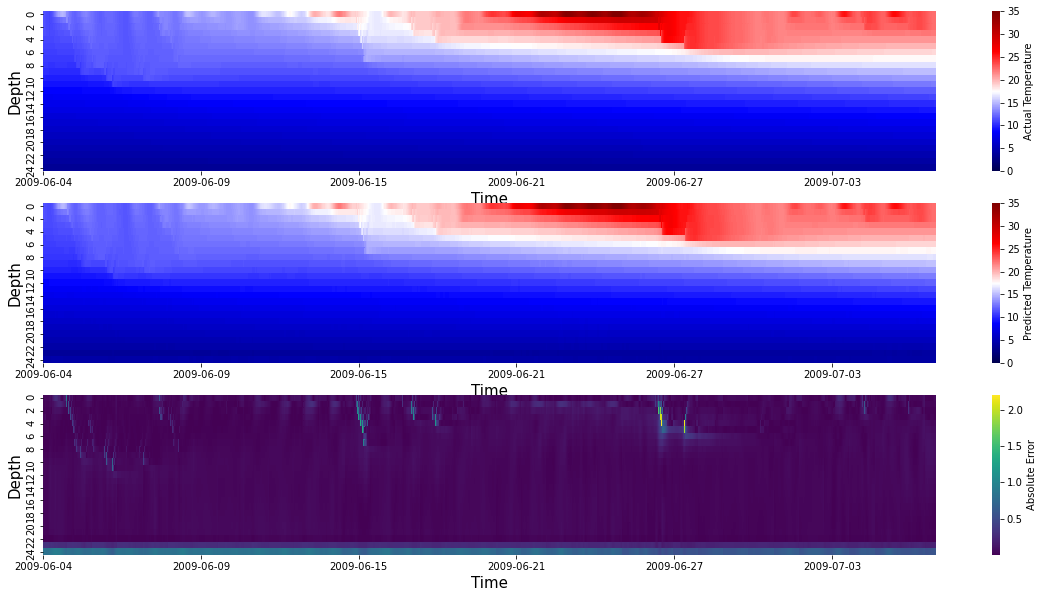

In [170]:
plot_output(train_y_pred, train_y_true, depth_steps, train_time, figsize=(20,10))

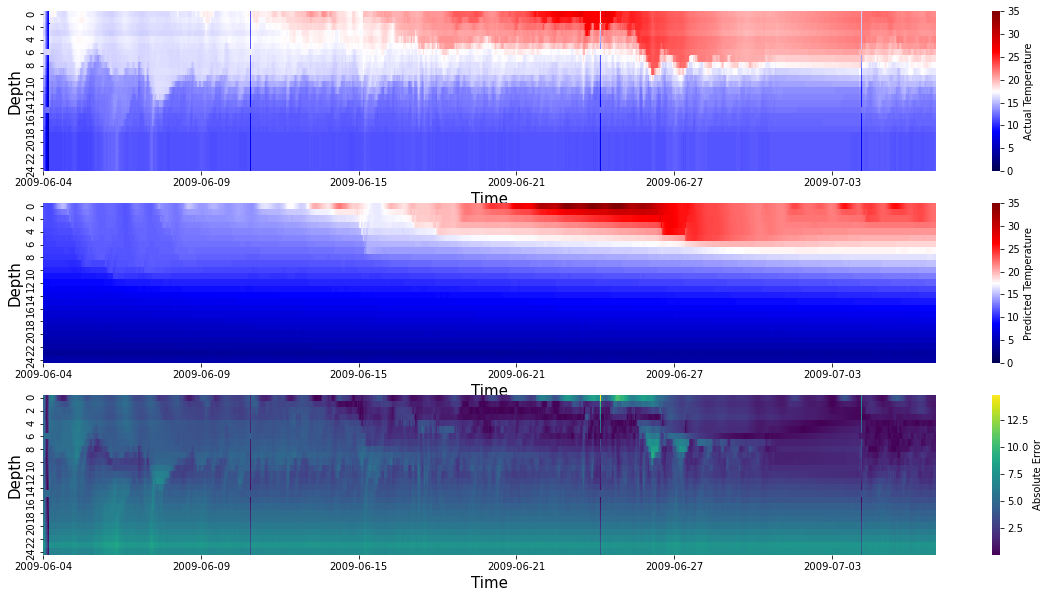

In [171]:
plot_output(train_y_pred, train_y_obs, depth_steps, train_time, figsize=(20,10))

In [172]:
test_y_pred, test_y_true, test_y_obs, test_rmse_models = get_rollout_predictions(heating_model, heat_diff_model, mixing_model, convection_model, ice_model, test_loader, plot = True)

test_rmse = rmse(test_y_pred.flatten(), test_y_true.flatten())
test_rmse_obs = rmse(test_y_pred.flatten(), test_y_obs.flatten())
test_l2 = l2_error(test_y_pred.flatten(), test_y_true.flatten())

print(f"Test RMSE Simulated: {test_rmse}")
print(f"Test RMSE Observed Temp: {test_rmse_obs}")
print(f"test L2 Error: {test_l2}")
print(f"The RMSEs after each modelling stage: {test_rmse_models.mean(axis=0)}")

RMSE of after m0 0.06562188
RMSE of after m1 0.16043976
RMSE of after m2 0.15351717
RMSE of after m3 0.14506786
RMSE of after m4 0.14043269
RMSE of after m0 0.10146639
RMSE of after m1 0.17668022
RMSE of after m2 0.16915813
RMSE of after m3 0.15999329
RMSE of after m4 0.15487155
RMSE of after m0 0.17078224
RMSE of after m1 0.20513721
RMSE of after m2 0.20749241
RMSE of after m3 0.19924499
RMSE of after m4 0.19916195
RMSE of after m0 0.26712635
RMSE of after m1 0.27675706
RMSE of after m2 0.3258594
RMSE of after m3 0.3195331
RMSE of after m4 0.31618166
RMSE of after m0 0.44920224
RMSE of after m1 0.43909428
RMSE of after m2 0.4563714
RMSE of after m3 0.441999
RMSE of after m4 0.43868962
RMSE of after m0 0.681121
RMSE of after m1 0.6666648
RMSE of after m2 0.6950656
RMSE of after m3 0.6851868
RMSE of after m4 0.70714927
RMSE of after m0 0.7807158
RMSE of after m1 0.7671743
RMSE of after m2 0.8130749
RMSE of after m3 0.8096332
RMSE of after m4 0.84116566
RMSE of after m0 0.7658944
RMSE of

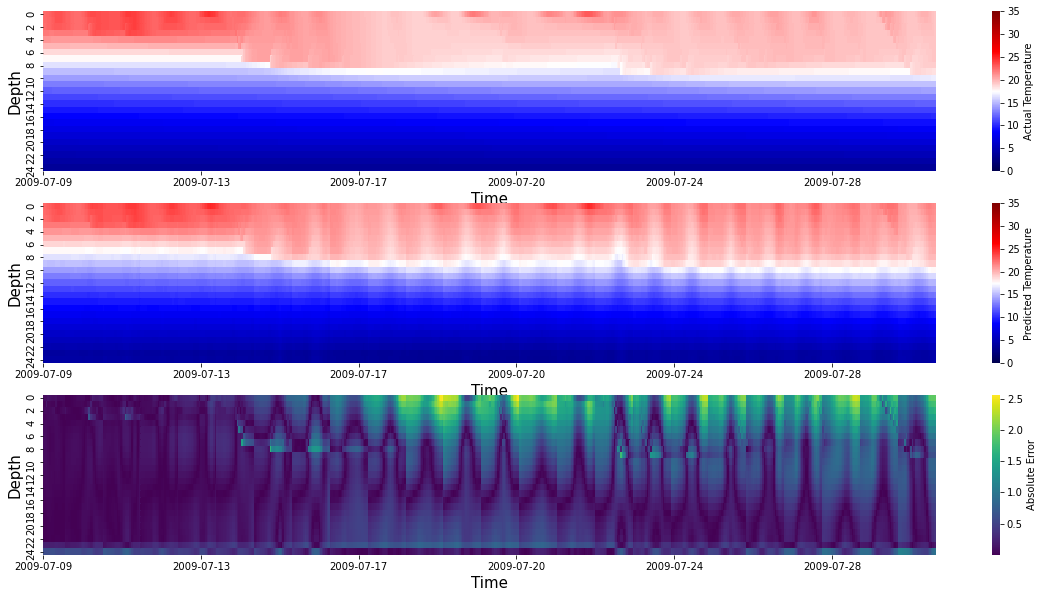

In [173]:
plot_output(test_y_pred, test_y_true, depth_steps, test_time, figsize=(20,10))

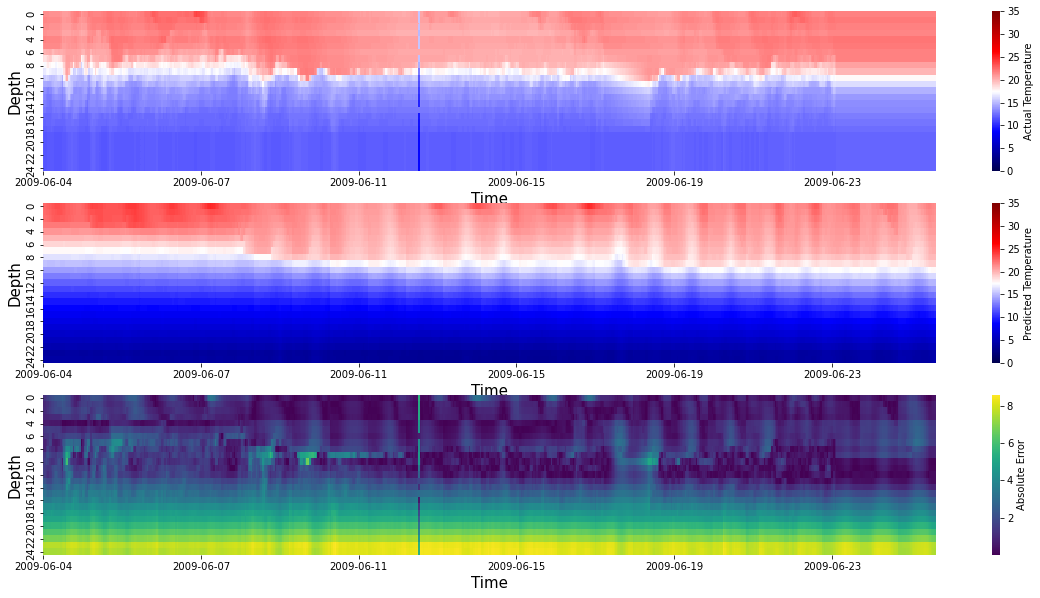

In [174]:
plot_output(test_y_pred, test_y_obs, depth_steps, train_time, figsize=(20,10))

# Evaluate ALL Models individually

## Heat Diffusion Model

In [175]:
train_rmse, train_l2_err = compute_metrics(heat_diff_model, train_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(heat_diff_model, test_loader, m1_input_column_ix, m1_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 15.524302731735185, Train L2 Error: 1.2127655355928177
Test RMSE: 10.25258516231879, Train L2 Error: 0.7061030542496609


## Mixing Model

In [176]:
train_rmse, train_l2_err = compute_metrics(mixing_model, train_loader, m2_input_column_ix, m2_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(mixing_model, test_loader, m2_input_column_ix, m2_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.06464672824655986, Train L2 Error: 0.005050188168577174
Test RMSE: 0.17823362266681597, Train L2 Error: 0.012274653288983025


## Convection Model

In [177]:
train_rmse, train_l2_err = compute_metrics(convection_model, train_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(convection_model, test_loader, m3_input_column_ix, m3_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.007789867537878315, Train L2 Error: 0.000608548609448087
Test RMSE: 0.0453234012849974, Train L2 Error: 0.0031213991515471797


## Ice Model

In [178]:
train_rmse, train_l2_err = compute_metrics(ice_model, train_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Train RMSE: {train_rmse}, Train L2 Error: {train_l2_err}")

test_rmse, test_l2_err = compute_metrics(ice_model, test_loader, m4_input_column_ix, m4_output_column_ix, train_mean, train_std)
print(f"Test RMSE: {test_rmse}, Train L2 Error: {test_l2_err}")

Train RMSE: 0.002282330588951952, Train L2 Error: 0.000178296883670224
Test RMSE: 0.12300266909677181, Train L2 Error: 0.00847113005801246


# Compute Model Similarity after Finetuning

In [179]:
def compute_model_similarity(model1, model2):
    weight1 = []
    weight2 = []
    for param1, param2 in zip(model1.parameters(), model2.parameters()):
        weight1.append(param1.detach().clone().flatten())
        weight2.append(param2.detach().clone().flatten())
    weight1 = torch.cat(weight1, dim=0)
    weight2 = torch.cat(weight2, dim=0)
    
    #Cosine Similarity
    cos = nn.CosineSimilarity(dim=0, eps=1e-8)
    cos_sim = cos(weight1, weight2)
    
    #L2 norm
    l2 = torch.norm((weight1-weight2), p='fro', dim=0)
    
    return cos_sim, l2

In [180]:
heat_diff_model_init = MLP(m1_layers, activation="gelu")
heat_diff_model_init.load_state_dict(m1_checkpoint)
heat_diff_model_init = heat_diff_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(heat_diff_model_init, heat_diff_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 0.9595852494239807
L2 Norm: 2.442401170730591


In [181]:
mixing_model_init = MLP(m2_layers, activation="gelu")
mixing_model_init.load_state_dict(m2_checkpoint)
mixing_model_init = mixing_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(mixing_model_init, mixing_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [182]:
convection_model_init = MLP(m3_layers, activation="gelu")
convection_model_init.load_state_dict(m3_checkpoint)
convection_model_init = convection_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(convection_model_init, convection_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0


In [183]:
ice_model_init = MLP(m4_layers, activation="gelu")
ice_model_init.load_state_dict(m4_checkpoint)
ice_model_init = ice_model_init.to(device)

cos_sim, l2_dist = compute_model_similarity(ice_model_init, ice_model)

print(f"Cosine Similarity: {cos_sim}")
print(f"L2 Norm: {l2_dist}")

Initializing Network with Xavier Initialization..
Cosine Similarity: 1.0
L2 Norm: 0.0
